For my project I chose the dataset '10000 Most Common Passwords' from SecLists. The dataset includes the passwords, length and the number of characters, numbers, upper/lowercase letters, special characters, vowels, and syllables.

In [1]:
import numpy as np 
import pandas as pd
import graphviz
import seaborn as sn
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn import cluster, tree
from scipy.cluster import hierarchy
from mlxtend.preprocessing import TransactionEncoder
from IPython.display import Image
%matplotlib inline

In [2]:
#reads CSV file & displays first 5 rows
data = pd.read_csv("../input/10000-most-common-passwords/common_passwords.csv")
data.columns = ['password','length','num_chars','num_digits','num_upper','num_lower','num_special','num_vowels','num_syllables']
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 10000
Number of attributes = 9


,password,length,num_chars,num_digits,num_upper,num_lower,num_special,num_vowels,num_syllables
0,123456,6,0,6,0,0,0,0,1
1,password,8,8,0,0,8,0,2,2
2,12345678,8,0,8,0,0,0,0,1
3,qwerty,6,6,0,0,6,0,1,3
4,123456789,9,0,9,0,0,0,0,1


In [3]:
for col in data.columns:
    if is_numeric_dtype(data[col]):
        print('%s:' % (col))
        print('\t Mean = %.3f' % data[col].mean())
        print('\t Standard deviation = %.2f' % data[col].std())
        print('\t Minimum = %.2f' % data[col].min())
        print('\t Maximum = %.2f' % data[col].max())

length:
	 Mean = 6.651
	 Standard deviation = 1.37
	 Minimum = 3.00
	 Maximum = 16.00
num_chars:
	 Mean = 5.030
	 Standard deviation = 2.80
	 Minimum = 0.00
	 Maximum = 13.00
num_digits:
	 Mean = 1.618
	 Standard deviation = 2.97
	 Minimum = 0.00
	 Maximum = 12.00
num_upper:
	 Mean = 0.025
	 Standard deviation = 0.32
	 Minimum = 0.00
	 Maximum = 8.00
num_lower:
	 Mean = 5.005
	 Standard deviation = 2.81
	 Minimum = 0.00
	 Maximum = 13.00
num_special:
	 Mean = 0.003
	 Standard deviation = 0.12
	 Minimum = 0.00
	 Maximum = 6.00
num_vowels:
	 Mean = 1.806
	 Standard deviation = 1.24
	 Minimum = 0.00
	 Maximum = 10.00
num_syllables:
	 Mean = 1.607
	 Standard deviation = 0.68
	 Minimum = 0.00
	 Maximum = 6.00


Num_chars, num_digits, and num_lower have the largest standard deviations becuase they have the most variance between the data. The mean for num_special and num_upper is extremly low, which means most of them will be probably be outliers.

In [4]:
#this is just neat
print('number of passwords with special characters : ')
print(data.shape[0] - data['num_special'].value_counts()[0])
print('number of passwords with uppercase letters : ')
print(data.shape[0] - data['num_upper'].value_counts()[0])

number of passwords with special characters : 
12
number of passwords with uppercase letters : 
119


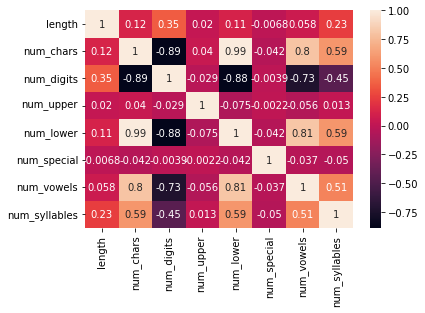

In [5]:
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

The highest correlation is between num_lower and num_chars. One of the main trends in the data is that most passwords are either entirely characters, or entirely digits. This causes an extremly high negative correlation betweent the two (-.89), and its almost the same for lowercase characters as well (-.88). However there is barely any correlation between the number of uppercase letters and the number of characters (.04).
There is also an extremly high correlation between the number of characters and the number of lowercase characters (.99) because most of the passwords that contain characters are exclusivly lowercase.

# Preprocessing

First I checked to see if there were no missing values, and luckily there weren't any. Then I removed the duplicate data (only two row).

In [6]:
#Shows no missing values
data = data.replace('?',np.NaN)
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of instances = 10000
Number of attributes = 9
Number of missing values:
	password: 0
	length: 0
	num_chars: 0
	num_digits: 0
	num_upper: 0
	num_lower: 0
	num_special: 0
	num_vowels: 0
	num_syllables: 0


In [7]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data.shape[0]))

Number of rows before discarding duplicates = 10000
Number of rows after discarding duplicates = 9998


<AxesSubplot:>

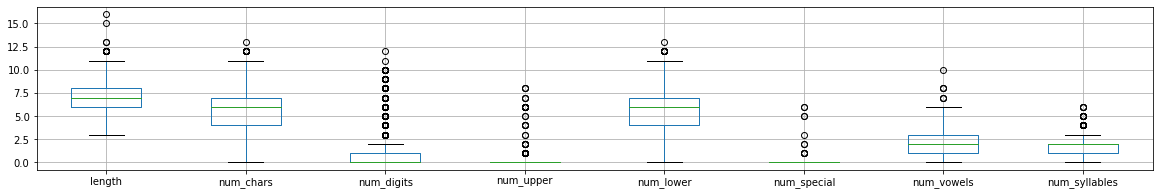

In [8]:
#Drops password column so only working with numbers & displays boxplot of outliers
data2 = data.drop(['password'],axis=1)
data2.boxplot(figsize=(20,3))

There are a quite a few of outliers in the data. There's not a box for num_upper & num_special because the min,1st quartile,median,3rd quartile, and the max are all 0. Anytime there is actually a password with an uppercase letter or a special character, it is automatically an outlier.  Since all of the columns have outliers, it will be fixed by calculating   the z-score will be computed for each attribute & the attributes with z-scores above or below 3 will be removed.

In [9]:
Z = (data2-data2.mean())/data2.std()
Z[:10]

,length,num_chars,num_digits,num_upper,num_lower,num_special,num_vowels,num_syllables
0,-0.475361,-1.793755,1.474394,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
1,0.983628,1.058962,-0.544367,-0.078358,1.065846,-0.028346,0.156245,0.577165
2,0.983628,-1.793755,2.147315,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
3,-0.475361,0.345783,-0.544367,-0.078358,0.354096,-0.028346,-0.648565,2.044738
4,1.713123,-1.793755,2.483775,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
5,-1.204855,-1.793755,1.137934,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
6,-1.934350,-1.793755,0.801474,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
7,-0.475361,-1.793755,1.474394,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
8,0.254134,-1.793755,1.810854,-0.078358,-1.781157,-0.028346,-1.453374,-0.890408
9,-0.475361,0.345783,-0.544367,-0.078358,0.354096,-0.028346,0.156245,0.577165


In [10]:
#discards outliers
print('Number of rows before discarding outliers = %d' % (Z.shape[0]))
Z2 = Z.loc[((Z > -3).sum(axis=1)==8) & ((Z <= 3).sum(axis=1)==8),:]
print('Number of rows after discarding outliers = %d' % (Z2.shape[0]))

Number of rows before discarding outliers = 9998
Number of rows after discarding outliers = 9738


# Clustering

For this dataset, aggregation didn't make sense because all of the passwords are unique. However 10,000 tuples is quite a lot, so I took a sample of 50 tuples to make it more manageable.

In [11]:
sample = data.sample(frac=0.005, random_state=1)
sample

,password,length,num_chars,num_digits,num_upper,num_lower,num_special,num_vowels,num_syllables
4559,kashmir,7,7,0,0,7,0,2,2
5362,momo,4,4,0,0,4,0,2,2
962,manutd,6,6,0,0,6,0,2,1
1757,assass,6,6,0,0,6,0,2,2
5857,istanbul,8,8,0,0,8,0,3,3
9707,crappy,6,6,0,0,6,0,1,2
4629,buddah,6,6,0,0,6,0,2,2
7298,tribal,6,6,0,0,6,0,2,2
1563,hobbit,6,6,0,0,6,0,2,2
9493,19111985,8,0,8,0,0,0,0,1


For the clustering, I only wanted to look at the password, length, and the number of digits, so I only selected those columns.

In [12]:
sample = data[['password','length','num_digits']]
sample = sample.sample(50)
sample

,password,length,num_digits
8213,fellow,6,0
2812,jojo,4,0
3522,shado,5,0
1851,brianna,7,0
3988,dorian,6,0
6642,14021985,8,8
1325,polaris,7,0
6082,temppass,8,0
1824,flatron,7,0
3604,12131415,8,8


In [13]:
clustering_data = sample.drop('password', axis = 1)
k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(clustering_data) 
labels = k_means.labels_
pd.DataFrame(labels, index=sample.password, columns=['Cluster ID'])

,Cluster ID
password,
fellow,0
jojo,0
shado,0
brianna,0
dorian,0
14021985,1
polaris,0
temppass,0
flatron,0


The clustering was pretty simple because almost all of the passwords followed the trend of being either all characters or all numbers, so those are the two groups they were clustered into. Cluster 0 being the cluster with majority characters, and cluster 1 wuth majority digits. 

In [14]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=['length','num_digits'])

,length,num_digits
0,6.261905,0.261905
1,8.000000,8.000000


Text(0, 0.5, 'SSE')

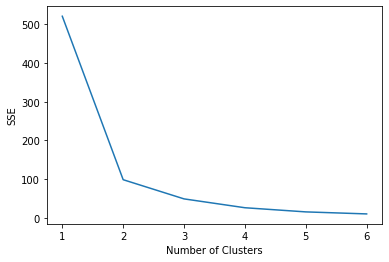

In [15]:
numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(clustering_data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

This graph shows that 2 clusters is the most effictive cluster number for this dataset.

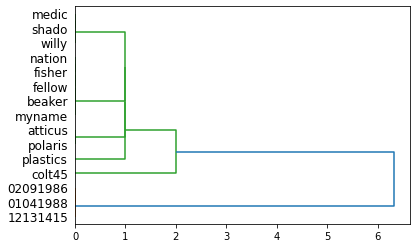

In [16]:
smaller_sample = sample.sample(15)
passwords = smaller_sample['password']
data_matrix = smaller_sample.drop(['password'],axis = 1)
linkage = hierarchy.linkage(data_matrix.values, 'single')
dn = hierarchy.dendrogram(linkage,labels=passwords.tolist(),orientation='right')

This shows that theres a lot of similarity between all of the passwords with only digits and the passwords with only characters, and the mixed passwords are somewhere in between.

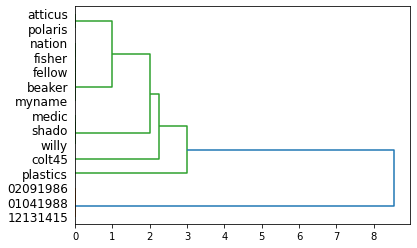

In [17]:
Z = hierarchy.linkage(data_matrix.values, 'complete')
dn = hierarchy.dendrogram(Z,labels=passwords.tolist(),orientation='right')

This shows basically the same thing as the graph before it, but it seperates the mixed passwords into a third group instead of having just connections between only numbers and only characters. It also shows that the mixed passwords are closer to the digits.

# Classification

In [18]:
data['length'] = data['length'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_chars'] = data['num_chars'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_digits'] = data['num_digits'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_upper'] = data['num_upper'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_lower'] = data['num_lower'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_special'] = data['num_special'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data['num_vowels'] = data['num_vowels'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 1)
data.columns = ['password','length','chars','digits','upper','lower','special','vowels','num_syllables']
data.head()

,password,length,chars,digits,upper,lower,special,vowels,num_syllables
0,123456,1,0,1,0,0,0,0,1
1,password,1,1,0,0,1,0,1,2
2,12345678,1,0,1,0,0,0,0,1
3,qwerty,1,1,0,0,1,0,1,3
4,123456789,1,0,1,0,0,0,0,1


Instead of of the number of each occurance, it now has 1 for true or it remains 0 if the attribute doesnt occur. I also changed the titles of the columns to make it easier to understand. It would have been easier to do this with transaction encoder. however every time I tried to do it, it messed up the data, so heres a failed attempt at that. 


In [19]:
#tried to do a transation encoder but it wouldn't work so I harded coded it ^
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,_,a,b,c,d,e,g,h,i,l,...,n,o,p,r,s,t,u,v,w,y
0,False,True,False,False,True,False,False,False,False,False,...,False,True,True,True,True,False,False,False,True,False
1,False,False,False,False,False,True,True,True,False,True,...,True,False,False,False,False,True,False,False,False,False
2,False,True,False,True,False,False,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
3,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,True,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9994,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


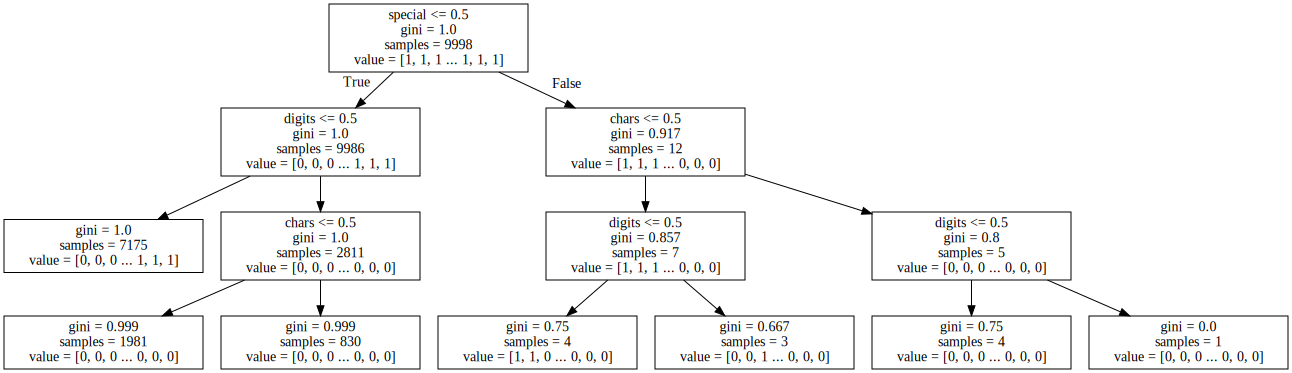

In [20]:
Y = data['password']
X = data.drop(['password','num_syllables','upper','lower','vowels'],axis=1)
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
clf = clf.fit(X, Y)
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X, Y)
data = tree.export_graphviz(dtree,feature_names = ['length','chars','digits','special'], out_file=None)
graph = graphviz.Source(data)
graph